# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm, proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). The support webpage can be found here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm discovers the discords of arbitrary length in time series. It is worthwhile to note that the term arbitrary means the user can define a range for the length of discord (i.e. minimum length, `min_m`, and maximum length, `max_m`), and the algorithm finds discords of different lengths $m \in [min\_m, max\_m]$.

## What is a discord?
A subsequence of length `m` in a time series `T` is a discord **iff** it has the largest distance (hereafter being referred to as `discord_dist`) to its [first] nearest neighbor (NN). The neighbors of a subsequence of length `m`, starting at index `i`, is any other subsequences that start at an index `j`, such that `j!=i`. However, if `i` and `j` are very close to each other, the comparison between their corresponding subsequences is considered to be trivial. To this end, an exclusion zone (`excl_zone`) is taken into account to ignore the neighbors (i.e. subsequences) whose starting index is in numpy indexing `[i-excl_zone : i+excl_zone+1]`. 

**NOTE:** <br>
It is important to note that for the i-th subsequence (i.e. `S = T[i:i+m]`), some of its neighbors are located on the left side of `S` (i.e. the ones with starting index less than/equal to `max(0, i-excl_zone-1)`) and some of its neighbors are located on the right side of `S` (i.e. the ones with starting index greater than/equal to `min(len(T), i+excl_zone+1)`). To find the NN of a subsequence `S`, the distance between `S` and all of its [left and right] neighbors must be obtained.

## Matrix Profile approach

How can we discover a discord of length `m` using matrix profile(`P`)? The solution is straightforward. `P` shows the distance of each subsequence to its NN. Therefore, the one that has the greatest distance to its NN is considered as the discord.

* **Advantage** <br>
Once we have the `P`, finding the discord is easy. Also, one can obtain the `top-k` discords very quickly.

* **Disadvantage** <br>
`P` needs to be calculated for each new length `m` in `[min_m, max_m]`, and, consequently, all pair-wise distances between subsequences must be calculated again. Because, ALL pairwise distances are required for obtaining `P`. 

As will be shown later, `MERLIN` can skip some  of the pair-wise distance calculations.

## MERLIN

There are two main ideas at the core of the `MERLIN` algorithm. In below, we briefly explain each concept. Then, we will show its implementation and discuss its performance.

### Idea (1): Elimination Approach
The idea can be explained as follows: Suppose we are told that the discord distance (`discord_dist`), that is, the distance between the discord and its nearest neighbor, for subsequences of length `m` is at least `r` (Please note that the "how" of setting `r` will be explained later in Idea(2)). That means the distance between the discord and each one of its neighbors is at least `r`. We start scanning the subsequences. If, for a subsequence `S`, we realize that it has a neighbor to which its distance is smaller than `r`, we ignore `S`.

The main idea is to eliminate all subsequences for which there exist at least one neighbor with pair-wise distance less than `r`. Therefore, the remaining subsequences (i.e. candidates) are the ones that have a distance great than/equal to `r`. Now that we narrowed down the candidates, we can search among them and find the NN of each candidate and discover the discord. 

**Note:** We can think of `r` as an estimate of discord_dist. Ideally, we would like to set this value to the discord distance or just a little less than the discord distance. However, the distance is unknown at this point, so the user can provide an estimate `r`. The provided value `r` might be an underestimation of true discord distance or an overestimation (We consider the case `r <= discord_dist` as underestimation here) If it is an underestimation, it means discord distance is at least `r`. Therefore, we will end up with some (at least 1) candidates that have distances `>=r` with all of their neighbors. However, if we overestimate `r`, we find no candidates (and therefore, we cannot find discord). To this end, we need to reduce the threshold `r` and try again. However, if we reduce `r` drastically, we may end up with a very bad underestimation of discord distance, which can lead to lots of candidates. But, what we are after is a small number of candidates so that we can search among them for discords in a short amount of time.

---

The smaller number of candidates, the better. This is where choosing a good value for `r` becomes important. For instance, let us consider two very extreme scenarios:

**Scenario I:** Choosing a VERY SMALL value for `r`. In this case, we can end up with almost all subsequnces as the candidates.

**Scenario II:** Choosing a VERY LARGE value for `r`. In this case, we can end up with no candidates at all. 


### Idea (2): Choosing `r`
The value of `r` can be set by the user. However, this is very rare as user usually do not know the proper value for `r`. In MERLIN algorithm, the parameter `r` is initially set to the largest possible value (more on this below). And, then the algorithm tries to gradually reduce it in an iterative manner till it finds at least one candidate.

## z-normalized and non-normalized Euclidean distance <br>
Please note that the [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf) paper used z-normalized euclidean distance to calculate the distance between any two subsequence. In this work, our focus is on both normalized- and non-normalized- Euclidean distances. In the following, we will show how we can use dot product to calculate these two distances. Using dot product will help us to use the power of vectorization in the (more efficient) implementation of the  algorithm.

**z-normalizd Eucludiean distance ($ED_{z-norm}$):** <br>
$ED_{z-norm}$ and the Pearson correlation ($PC$), between any two subsequences with length $m$, are related as follows [(berthold2016)](https://arxiv.org/pdf/1601.02213.pdf):

$ED_{z-norm} = \sqrt{2 \times m \times (1-PC)}$ 

On the other hand, the $PC$ can be calculated as $PC = \frac{E[(X-\mu_{X})(Y-\mu_{Y})]}{\sigma_{X}\sigma_{Y}}$, which can be re-written as follows:

$PC = \frac{{\frac{1}{m}}{\sum\limits_{t=1}^{m}} {(X_{t} - \mu_{X})((Y_{t} - \mu_{Y}))}}{\sigma_{X}\sigma_{Y}}$.

Please note that a z-normalized subsequence has a mean ($\mu$) of 0 and standard deviation ($\sigma$) of 1. Therefore, the pearson correlation between two z-normalized subsequences becomes:

$PC = {\frac{1}{m}} <X_{z}, Y_{z}>$, where $<X_{z}, Y_{z}>$ is the dot product between two vectors $X_{z}$ and $Y_{z}$, where $X_{z}$ ($Y_{z}$) is a vector consists of the values of the subequene obtained by z-normalizing the subsequence $X$ ($Y$).


So, the first formula becomes: <br>
$ED_{z-norm} = \sqrt{2 \times m \times (1 - {\frac{1}{m}} <X_{z}, Y_{z}>)}$ 



Therefore, for a given $ED_{z-norm}$, one can calculate its corresponding dot product value as below: <br>
$<X_{z}, Y_{z}> = m \times (1 - \frac{1}{2m}{ED_{z-norm}^{2}})$ <br>
Thus, instead of comparing two z-normlized subsequences by calculating their (z-normlized) Euclidean distance, one can calculate the dot product of the two z-normalized subsequences. Please note that a higher z-normalized Euclidean distance means lower dot product value. So, instead of using `r` as the minimum distance a discord's candidate should have with all of its neighbors, one can use $m \times (1 - \frac{1}{2m}{r^{2}})$ as the maximum dot product value a discord's candidate should have with its neighbors.

**Initial value for $ED_{z-norm}$**: <br>
As discussed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf), the initial value for `r` is set to its maximum possible value. This can be achieved by choosing the lowest value for $PC$ (i.e. -1). In that case, it can be observed that the initial value for `r` is $2\sqrt{m}$.

---
**non-normalizd Eucludiean distance ($ED$):** <br>
$ED$ can still be calculated by the help of some dot products: <br>

$ED^{2} = {||X-Y||}^{2}  =  <X-Y , X-Y>  =  <X.X> + <Y.Y>  -  2<X,Y>$ <br>
Using the right hand side of the equation above may not make sense when we are iterating the subsequences in a for-loop one by one. However, in the more efficient version of MERLIN, where candidates are compared to more than one subsequencec in each iteration, this relationship can be helpful. We can calculate and store the two-norm of all subsequences in a 1-dim array. Then, we can use np.matmul() to calculate the last term (i.e. $<X,Y>$). We can get into further details later in the implementation.

**Initial value for $ED$**: <br>
Similar to the z-normalized case, we would like to set the value of the `r` to the maximum possible value. Therefore:

$min\_dist^{2} = max ({||X-Y||}^{2}) = max \sum\limits_{t=1}^{m}(X_{t} - Y_{t})^{2} =  \sum\limits_{t=1}^{m}max{(X_{t} - Y_{t})^{2}} = \sum\limits_{t=1}^{m}{[max (|X_{t} - Y_{t}|)]}^{2} =  \sum\limits_{t=1}^{m}{(T_{max} - T_{min})^2} = {m} \times{(T_{max} - T_{min})^2}$

where, $T_{max}$ ($T_{min}$) is the maximum (minimum) value of the main time series $T$.

And, this gives the maximum possible value for `r` as follows: <br>
$ min\_dist = (|T_{max} - T_{min}|) \sqrt{m}$

**NOTE:** Please note that, in practice, `T` might have infinite/nan values. In that case, `r` becomes infinite (and thus useless). To avoid this scenario, we should do: $T_{max} = np.max(T[np.isfinite(T)])$, and $T_{min} = np.min(T[np.isfinite(T)])$.

**Alternative Approach for initializing `r`**<br>
The algorithm MERLIN uses the highest possible distance between two subsequences as the initial value for `r`. However, there is an alternative approach. In STUMPY, `_prescrump` gives an approximate matrix profile which is an overestimation of the true matrix profile. Therefore, instead of setting `r` to the highest possible value (e.g, $2*\sqrt{m}$ in normalize case), we can simply set it to the highest value in approximate matrix profile.

## Implement MERLIN
It is worthwhile to note that a faster version of MERLIN is provided on the MERLIN's support webpage [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies). However, for now, we implement the version proposed in the original paper as it can be implemented in a cleaner/more understandable way.

### Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump
import numpy as np
import matplotlib.pyplot as plt
import math
import time

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

### Import (toy) data
data set is available at: 
https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view


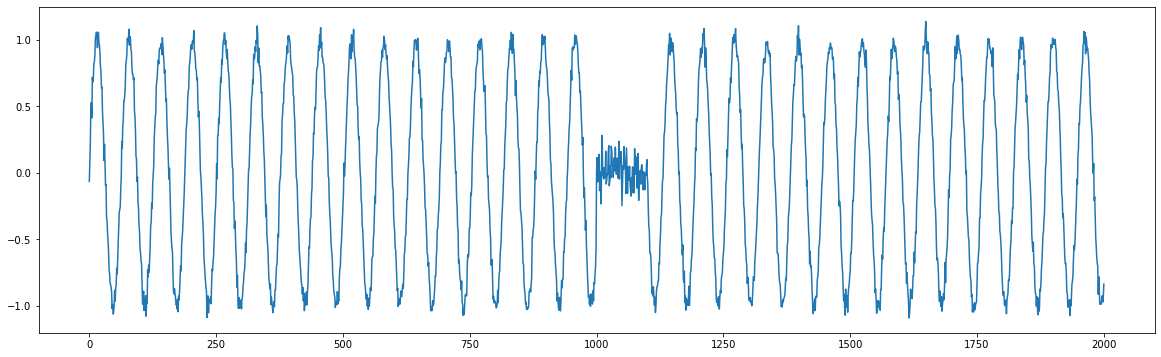

In [2]:
from scipy.io import loadmat

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

#visualize data
plt.plot(ts)
plt.show()

As we can see there is an anomaly located in about the middle of the time series data. We will implement MERLIN to discover the discord.

### MERLIN- Part (I): DRAG --> Find Candidates  \[for discord of length m\]
As explained before, the idea is to select a number of candidates by eliminating undesirable subsequences. A candidate is a subsequence whose distance to all of its neighbors are at least `r`. Then, we can search among these candidates and find the discord. 

This part can be done in two phases as follows:

**MERLIN-Part(I): DRAG - Phase (I) --> Find Candidates** <br>
In this phase, we compare each subsequence (i.e. potential candidate) with ALL of its RIGHT, and then LEFT neighbors (or vice versa).

In [3]:
def _get_chunks_ranges(a, shift=None):
    """
    This function takes an array that contains only integer numbers in ascending order, and return the
    `(inclusive) start index` and `(exclusive) stop index + shift` for each continuous segment of array.
    
    Parameters
    --------
    a : numpy.ndarray
        1-dim array that contains integer numbers in ascending order.
    
    shift : int, default None
        an integer number by which the stop index of each segement should be shifted. If None, no shift will be applied.
        
    Returns
    -------
    out : numpy.ndarray
        a 2-dim numpy array. The first column is the (inclusive) start index of each segment. The second column is the
        (exclusive) stop index shifted by `shift` units.
    """    
    repeats = np.full(len(a), 2)
    diff_is_one = np.diff(a) == 1
    repeats[1:] -= diff_is_one
    repeats[:-1] -= diff_is_one
    out = np.repeat(a, repeats).reshape(-1, 2)
    out[:, 1] += 1
    
    if shift is not None:
        out[:, 1] += shift

    return out

In [4]:
def _find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True, finite=False):
    """
    For a time series T, this function finds a set of candidates whose distance to all of their right (left) neighbors 
    is at least `r` when parameter `right` is TRUE (FALSE). If there is no such candidate, all elements of is_cands
    becomes False.
    
    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence from which the candidates are being selected.
    
    m : int
        Window size
    
    M_T : ndarray
        Sliding mean of `T`
    
    Σ_T : ndarray
        Sliding standard deviation of `T`
    
    r : float 
        An estimate of discord_dist. The selected candidates retuned by this function have distances of at least `r` 
        to all of their right(left) neighbors when input `right` is set to True(False).
        
        Choosing different values for `r`can affect the performance of the algorithm 
        (see Fig. 5 of the paper). For instance, choosing a very large value for `r` may result in no candidates 
        while choosing a very small value may result in a lot of candidates.  
        (note: `r` is passed to this private function when it is called inside the top-level function `_discords`).
    
    init_cands : numpy.ndarray, default None
        is a 1-dim boolean array, with shape=(k,) where `k` is the total number of subsquences in the time series. 
        `init_cands[i]` is True if the subsequence with start index `i` is considered as one of the 
        prospective candidates.
        
    right : bool, default True
        If True (False), candidates returned by the function are guaranteed to have at least the distance of `r` 
        to all of their 'right`('left') neighbors.
    
    finite : bool, default False
        If True, subsequence with infinite values will not be considered as candidates.   
    
    Returns
    --------
    is_cands : numpy.ndarray
        is a 1-dim boolean array, with shape=(k,) where `k` is the total number of subsquences in the time series. 
        `is_cands[i]` is True if the subsequence with start index `i` has minimum distance of `r` to all of its 
        right (left) neighbors when right is True (False).
    
    NOTE
    -------    
    Unlike the MERLIN paper where the exclusion zone is m, the default exclusion zone considered here
    is the STUMPY default config m/4. This can be changed by setting config.STUMPY_EXCL_ZONE_DENOM.
    """    
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    k = T.shape[0] - m + 1 
    
    is_cands = np.ones(k, dtype=bool)
    if init_cands is not None:
        is_cands[:] = init_cands
    
    T_subseq_isfinite = np.isfinite(M_T)
    if not finite:
        T_subseq_isfinite[:] = True
    is_cands[~T_subseq_isfinite] = False
    
    for i in np.flatnonzero(T_subseq_isfinite):
        if np.all(is_cands == False):
            break
            
        cands_idx = np.flatnonzero(is_cands)
        
        if right: 
            non_trivial_cands_idx = cands_idx[cands_idx < max(0, i - excl_zone)]
        else:
            non_trivial_cands_idx = cands_idx[cands_idx > i + excl_zone]
        
        if len(non_trivial_cands_idx) > 0:        
            cand_idx_chunks = _get_chunks_ranges(non_trivial_cands_idx, shift=m-1) 
            #shift=m-1: convert from subsequence space to time series space
            
            for start, stop in cand_idx_chunks:
                QT = core._sliding_dot_product(T[i:i+m], T[start:stop]) 
                D = core._mass(T[i:i+m], T[start:stop], QT, M_T[i], Σ_T[i], M_T[start:stop-m+1], Σ_T[start:stop-m+1])

                mask = np.flatnonzero(D < r)   
                is_cands[start:stop-m+1][mask] = False

                if len(mask):
                    is_cands[i] = False
        
    return is_cands

In [5]:
#input (as provided by the  authors of paper)
m = 512 
r = 10.27 #r is not required for MERLIN. This is just to show the code works in this private function.

T, M_T, Σ_T = core.preprocess(ts, m)

In [6]:
is_cands = _find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
cand_index = np.flatnonzero(is_cands)
cand_index

array([ 584,  585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
        595,  596,  597,  598,  599,  600,  601,  602,  603,  604,  613,
        614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,
        625,  626,  627,  628,  629,  630,  631,  632,  633,  634,  646,
        647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,
        658,  659,  660,  661,  662,  663,  664,  665,  677,  678,  679,
        680,  681,  682,  683,  684,  685,  686,  687,  688,  689,  690,
        691,  692,  693,  694,  695,  696,  710,  711,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  749,  750,  751,  780,  781,
        906,  907,  908, 1361, 1362, 1363, 1364, 1367, 1368, 1369, 1370,
       1371, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388,
       1393, 1394, 1395, 1396, 1400, 1401, 1402, 1403, 1404, 1405, 1406,
       1407, 1408, 1409, 1410, 1411, 1415, 1416, 1417, 1418, 1419, 1421,
       1422, 1423, 1424, 1425, 1426, 1427, 1428, 14

The number of so-far-selected candidates (188) are about one-tenth of total number of subsequences (1490). Also, some of them might be False Positives (that will be handled when scanning neighbors of the other direction.). 

Let's see if the anomaly part of the time series is covered by the selected candidates:

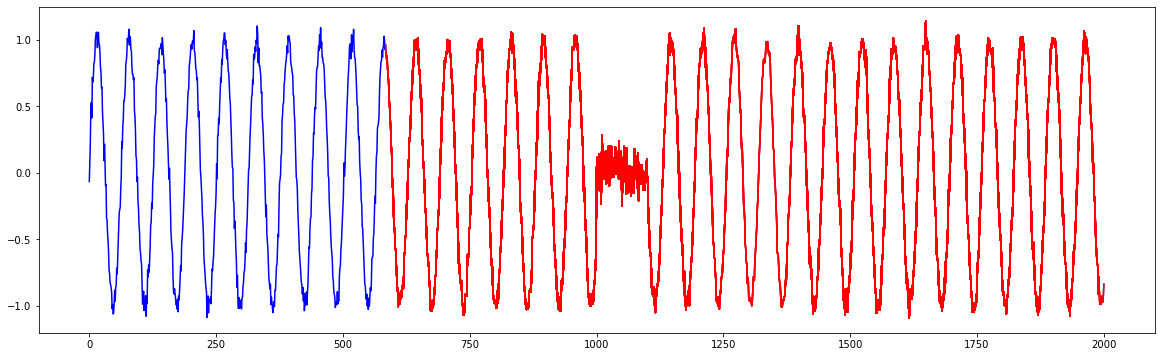

In [7]:
plt.plot(T, c='b')
for idx in cand_index:
    plt.plot(np.arange(idx,idx+m), T[idx:idx+m], c='r')
plt.show()

As illustrated, the selected candidates cover the anomaly. Next, we use the same function to compare subsequences with their left neighbors.

In [8]:
is_cands = _find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)
cands

array([592, 593, 594, 621, 622, 623, 624, 625, 626, 627, 652, 653, 654,
       655, 656, 657, 658, 659, 683, 684, 685, 686, 687, 688, 689, 690,
       691, 715, 716, 717, 718, 719, 720, 749, 750, 751, 780, 781, 906,
       907, 908], dtype=int64)

The number of final candidates (41) is about 3% of total number of subsequences (1490). In other words, out of the initial number of candidates (i.e. 1490), we just need to search among the 41 final candidates. 

**Check if the dicord is covered by final candidates** <br>
Let us see if the anomaly part of the time series is covered by these final candidates:

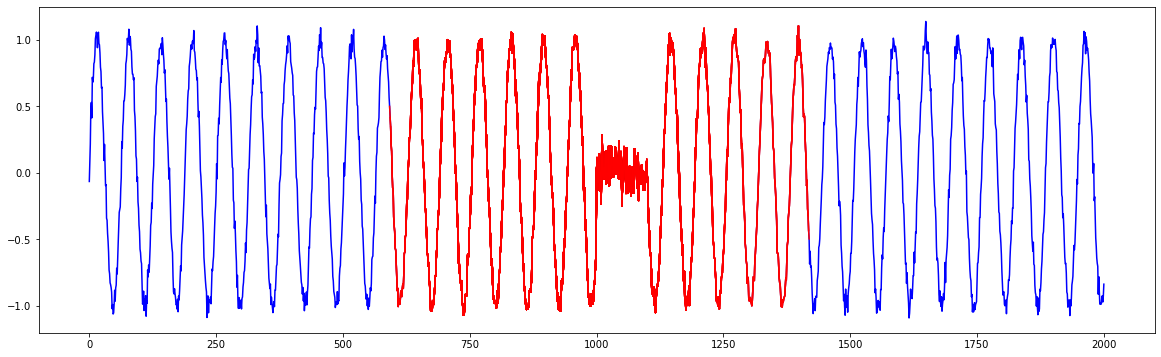

In [9]:
plt.plot(T, c='b')
for idx in cands:
    plt.plot(np.arange(idx,idx+m), ts[idx:idx+m], c='r')
plt.show()

As illustrated in the figure above, the candidate covers the anomaly of the time series data. Please note that it is possible that some of the candidates may not cover the anomaly. For example, recall the scenario where `r` is very small. In that case, most subsequences are going to be returned as candidates. So, it is NOT reasonable to expect all candidates cover the anomaly. 

**MERLIN-Part(I): DRAG - Phase (II) --> Find Discord**<br>
After pruning the false positive candidates, we can find the NN of each of the remaining candidates. The candidate that has the greatest distance to its NN is the top-discord of that set of candidates.

In [10]:
def _get_approx_P(T, m, M_T, Σ_T, s):
    """
    This function returns the (approximate) matrix profile. 
    
    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence for which the approximate matrix profile is calculated.
    
    m : int
        Window size
    
    M_T : ndarray
        Sliding mean of `T`
    
    Σ_T : ndarray
        Sliding standard deviation of `T`
    
    s : int
        The sampling interval
    
    Returns
    ---------
    P : numpy.ndarray
        Matrix profile
    """
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    k = T.shape[0] - m + 1
    
    indices = np.random.permutation(range(0, k, s)).astype(np.int64)
    P, _ = _prescrump(
        T,
        T,
        m,
        M_T,
        Σ_T,
        M_T,
        Σ_T,
        indices,
        s,
        excl_zone,
    )
    
    return P

In [23]:
def _refine_candidates(T, m, M_T, Σ_T, is_cands):
    """
    For a time series `T`, this function searches the candidates (i.e. subsequences indicated by `is_cands`) and 
    return candidates discords in descending order according to their distance to their nearest neighbor.
    After finding the top-discord among candidates, the discord subsequence and its trivial neighbors will be excluded 
    from candidates before finding the next top-discord.
 
    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence from which the top discord (out of selected candidates) is discovered. 
    
    m : int
        Window size
    
    M_T : numpy.ndarray
        Sliding mean of `T`
    
    Σ_T : numpy.ndarray
        Sliding standard deviation of `T`
    
    is_cands : numpy.ndarray
        is a 1-dim boolean array, with shape=(k,) where `k` is the total number of subsquences in the time series. 
        when `is_cands[i]` is True, a subsequence with start index `i` is a discord candidate.
     
    Returns
    ---------
    out : numpy.ndarray
        is a 2-dim array with three columns. The first column is indices of discords, sorted according to their 
        corresponding distances to their nearest neighbor, provided in the second column. 
        The third column is the indices of the discords' nearest neighbor. 
    """    
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)) 
    k = T.shape[0] - m + 1
    
    P = np.full(k, np.NINF, dtype=np.float64) # matrix profile
    I = np.full(k, -1, dtype=np.int64) # index of Nearest Neighbor 
    
    for idx in np.flatnonzero(is_cands): 
        Q = T[idx:idx+m]
        QT = core._sliding_dot_product(Q, T)
        D = core._mass(Q, T, QT, M_T[idx], Σ_T[idx], M_T, Σ_T)
        core.apply_exclusion_zone(D, idx, excl_zone, val=np.inf)
        
        nn_idx = np.argmin(D)  
        if D[nn_idx] == np.inf:
            nn_idx = -1
        P[idx] = D[nn_idx]
        I[idx] = nn_idx
    
    discords_idx = []
    discords_dist = []
    discords_nn_idx = [] 
    while np.any(P>=0):
        idx = np.argmax(P)
        discords_idx.append(idx)
        discords_dist.append(P[idx])
        discords_nn_idx.append(I[idx])  
        core.apply_exclusion_zone(P, idx, excl_zone, np.NINF)
     
    return discords_idx, discords_dist, discords_nn_idx

In [15]:
s = int(0.001 * T.shape[0])
approx_P = _get_approx_P(T, m, M_T, Σ_T, s)
discords_idx, discords_dist, discords_nn_idx = _refine_candidates(T, m, M_T, Σ_T, is_cands)

print('the index of discord is: ', discords_idx)
print('distance of discord to its NN is: ', discords_dist)
print('the index of NearestNeighbor of the discord is: ', discords_nn_idx)

the index of discord is:  [718, 906]
distance of discord to its NN is:  [10.301397123538967, 10.271812911147354]
the index of NearestNeighbor of the discord is:  [278, 1283]


**Now, let us use matrix profile (of stumpy package) to make sure the output of MERLIN-Part(I) is correct:**

In [16]:
excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))

mp = stumpy.stump(T, m)
P = mp[:,0].astype(np.float64) #p: matrix profile (dist of each subseq to its NN)

mp_discords_idx = [] #np.argmax(P)
mp_discords_dist = [] #P[mp_discord_idx]
mp_discords_nn_idx = [] #mp[mp_discord_idx,1]

for i in range(2): #2: number of discords discovered from candidates in _refine_candidates
    if np.any(P>=0):
        idx = np.argmax(P)
        mp_discords_idx.append(idx)
        mp_discords_dist.append(P[idx])
        mp_discords_nn_idx.append(mp[idx,1])
        core.apply_exclusion_zone(P, idx, excl_zone, np.NINF)
    

print('>>> using STUMPY matrix profile to find the discord <<<')
print('the index of discord is: ', mp_discords_idx)
print('dist of discord to its nn is: ', mp_discords_dist)
print('the index of nn of the discord: ', mp_discords_nn_idx)

>>> using STUMPY matrix profile to find the discord <<<
the index of discord is:  [718, 906]
dist of discord to its nn is:  [10.301397123538928, 10.271812911147341]
the index of nn of the discord:  [278, 1283]


### Finding `top-k` Discords (of length m)

In some cases, one might be interested in finding more than one discord. The authors of [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf) referred readers to the paper [DiskawareDiscords](https://www.cs.ucr.edu/~eamonn/DiskawareDiscords.pdf) for `top-k` discords. However, the paper [DiskawareDiscords](https://www.cs.ucr.edu/~eamonn/DiskawareDiscords.pdf) does not take into account the `excl_zone` when it tries to find the `top-k` discords. In other words, it can return the subsequences at `idx` and `idx+1` as the `top-2` discords! But, this is not a correct approach as the two discovered discords are the trivial match of each other! As one can observe in the MATLAB implementation of MERLIN provided in [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies), the `k-th` discord index should not be in the `exclusion area` of the previous `k-1` discords.

**> To find `top-k` discords** <br>
Let us assume we already discovered the the `top-k` discords. We can find the next discord (i.e the `k+1 -th` discord with length the same as the previously-discovered ones) as follows: <br>

(1) reduce `r` (so we can get more candidates!) <br>
(2) get candidates by function `_find_candidates()` while excluding the previously-discovered discords and their trivial matches. <br>
(3) Find the discords by using `_refine_candidates` function. <br> 

In [37]:
def _discords(T, m, k=1, r=None, decay=None, s=None, include=None, finite=False):
    """
    For a time series `T`, this function finds the top-k discords of length `m` with method MERLIN.

    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence from which to get the top-k discords

    m : int
        Window size

    k : int
        number of discords to be discovered.

    r : float, default None
        An initial value for r. An ideal value for r should be close to discord distance. 
        If you do not have a good guess about r, it is recommended leaving this parameter to None.
        The smallest value allowed for r is config.STUMPY_MIN_DISCORD_DISTANCE, which is set to 1e-6 by default.
        
    decay: numpy.ndarray, default None
        a 1-dim array of length k with values each between 0 and 1. 
        The decay[i] represents the rate of decrease of `r` for i-th discord. 

    s : int, default None
        The sampling interval, that defaults to int(0.001 * len(T)).

    include : ndarray, default None
        is a 1-dim boolean array, whose length is the total number of subsquences in the time series.
        `include[i]` is True if the subsequence with start index `i` is eligible to be considered as one of the
        prospective candidates. Therefore, if `include[i]` is False, `is_cands[i]` will be False as well.
        When include=None (default), all the elements of `include` are set to True.

    finite : bool, default False
        If True, subsequence with infinite values will be ignored.

    Returns
    --------
    out : ndarray
        has shape (k, 3). The i-th row cosists of information of i-th discord.
        First column is the discord index. Second column is the distance of discard to its Nearest Neighbor.
        And, third column is the index of discord's NearestNeighbor. The discords are sorted according to their 
        distances to their nearest neighbor. If  number of discovered discords is less than k, the remaining rows
        are filled with [-1, np.NINF, -1].

    NOTE:
    (1) It is important to note that when `include[i]` is False, the subsequence `i` is still considered
    as neighbors of other subsequences. This input is useful when a user wants to focus on detecting
    anomaly of a portion of time series (while considering patterns in the whole time series `T` as neighbors).

    (2) Please note that the rate of change for updating `r` is not science-backed.
    In MERLIN paper, they used 0.99 in some cases, and 0.95 in other cases as the rate-of-change factor.
    
    (3) In contrast to original work MERLIN, we use approximate matrix profile, which can help us in narrowding down our 
    search space. 
    """
    T, M_T, Σ_T = core.preprocess(T, m)
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    n = T.shape[0]
    l = n - m + 1
    
    if m < 3:
        raise ValueError(f"the length of subsequence, {m}, cannot be less than 3.")

    if decay is None:
        decay = np.full(k, 0.99)
    if np.any(decay <= 0.0) or np.any(decay >= 1.0):
        raise ValueError("All decay values must be between 0.0 and 1.0")

    if s is None:
        s = int(0.001 * n)
    approx_P = _get_approx_P(T, m, M_T, Σ_T, s)

    if include is None:
        include = np.ones(l, dtype=bool)
    if len(include) != l:
        raise ValueError(
            f"The length of include ({len(include)}) does not match " 
            f"the total number of subsequences ({l})"
        )

    if finite:
        include[~np.isfinite(M_T)] = False

    max_dist = 2.0 * np.sqrt(m) # better to do: max_dist = min(2.0 * np.sqrt(m), approx_P[include].max())
    if r is None or r > max_dist:
        r = max_dist
    if r < 1e-6: # config.STUMPY_MIN_DISCORD_DISTANCE = 1e-6
        raise ValueError(
            f" `r` ({r}) is less than `config.STUMPY_MIN_DISCORD_DISTANCE` ({config.STUMPY_MIN_DISCORD_DISTANCE})." 
            "Try increasing `r` or decreasing `config.STUMPY_MIN_DISCORD_DISTANCE`."
        ) 
      
    discords_idx = np.full(k, -1, dtype=np.int64)
    discords_dist = np.full(k, np.NINF, dtype=np.float64)
    discords_nn_idx = np.full(k, -1, dtype=np.int64)
    
    i=0
    r_updated = r
    while np.any(include):
        init_cands = include & (approx_P >= r_updated)
        is_cands = _find_candidates(T, m, M_T, Σ_T, r_updated, init_cands=init_cands, right=True, finite=finite)
        is_cands = _find_candidates(T, m, M_T, Σ_T, r_updated, init_cands=is_cands, right=False, finite=finite)
        
        if np.any(is_cands):
            IDX, D, NN_IDX = _refine_candidates(T, m, M_T, Σ_T, is_cands)
            for idx, dist, nn_idx in zip(IDX, D, NN_IDX):
                discords_idx[i] = idx
                discords_dist[i] = dist
                discords_nn_idx[i] = nn_idx
                core.apply_exclusion_zone(include, idx, excl_zone, val=False)
                i += 1
                if i==k:
                    break
            
        if r_updated <= 1e-6 or i==k: # config.STUMPY_MIN_DISCORD_DISTANCE = 1e-6
            break
        r_updated = max(r_updated * decay[i], 1e-6) # config.STUMPY_MIN_DISCORD_DISTANCE = 1e-6
    
    
    out = np.empty((k,3), dtype=object)
    out[:,0] = discords_idx
    out[:,1] = discords_dist
    out[:,2] = discords_nn_idx
    
    return out

In [31]:
tic = time.time()
out = _discords(T, m, k=15)
toc = time.time()
print('running time: ', toc-tic)
print('------------------------')
out

running time:  1.599726676940918
------------------------


array([[718, 10.301397123538967, 278],
       [906, 10.271812911147354, 1283],
       [589, 10.245937568875549, 149],
       [1035, 8.487378272524321, 1412],
       [1182, 2.2518328767162363, 114],
       [309, 2.2364873593725956, 1377],
       [154, 2.230473678558997, 1348],
       [1348, 2.230473678558997, 154],
       [1479, 2.2014556687630877, 285],
       [5, 2.1913006977345426, 382],
       [438, 2.169638390989113, 61],
       [-1, -inf, -1],
       [-1, -inf, -1],
       [-1, -inf, -1],
       [-1, -inf, -1]], dtype=object)

**Let us use (STUMPY) matrix profile to find `top-k` discords**

In [32]:
def stumpy_top_k_discords(T, m, k=1, finite=False):
    """
    This funciton use stumpy package to find the top-k discords of length m with help of matrix profile.
    
    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence from which to get the top-k discords
    
    m : int
        Window size
        
    k : int
        number of discords to be discovered.
    
    finite : bool, default False 
        If True, subsequence with infinite values will be ignored. 
    
    Returns
    --------
    out : ndarray
        has shape (k, 3). The i-th row cosists of information of i-th discord.
        First column is the discord index. Second column is the distance of discard to its Nearest Neighbor.
        And, third column is the index of discord's NearestNeighbor. The discords are sorted according to their 
        distances to their nearest neighbor. If  number of discovered discords is less than k, the remaining rows
        are filled with [-1, np.NINF, -1].
    
    """
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    mp = stumpy.stump(T, m)
    P = mp[:,0].astype(np.float64) #change the dtype to np.float64, so it can be used later in core.apply_exclusion_zone
    
    if finite:
        P[~np.isfinite(P)] = np.NINF
    
    discords_idx = np.full(k, -1, dtype=np.int64)
    discords_dist = np.full(k, np.NINF, dtype=np.float64)
    discords_nn_idx = np.full(k, -1, dtype=np.int64)
    
    for i in range(k):
        if np.all(P == np.NINF):
            break
        mp_discord_idx = np.argmax(P)
        
        discords_idx[i] = mp_discord_idx
        discords_dist[i] = P[mp_discord_idx]
        discords_nn_idx[i] = mp[mp_discord_idx,1]
        
        core.apply_exclusion_zone(P, discords_idx[i], excl_zone, val=np.NINF)
    
    out = np.empty((k, 3), dtype = object)
    out[:, 0] = discords_idx
    out[:, 1] = discords_dist
    out[:, 2] = discords_nn_idx
    
    return out

In [33]:
mp_out = stumpy_top_k_discords(T, m, k=15)
mp_out

array([[718, 10.301397123538928, 278],
       [906, 10.271812911147341, 1283],
       [589, 10.245937568875554, 149],
       [1035, 8.487378272524301, 1412],
       [1182, 2.25183287671611, 114],
       [309, 2.2364873593723926, 1377],
       [154, 2.2304736785589205, 1348],
       [1348, 2.2304736785589205, 154],
       [1479, 2.201455668762907, 285],
       [5, 2.191300697734491, 382],
       [438, 2.1696383909891916, 61],
       [-1, -inf, -1],
       [-1, -inf, -1],
       [-1, -inf, -1],
       [-1, -inf, -1]], dtype=object)

As observed, the outputs of `murlin` and `stumpy_top_k_discords` are the same in finding the `top-k` (`k=10`) discords (please see below).

In [34]:
#compare the output of murlin and stumpy_top_k_discord
np.testing.assert_almost_equal(mp_out[:-4], out[:-4]) #last four items are np.NINF

**Now, let us see the results when the time series has np.nan / np.inf values:**

In [35]:
T[100:200] = np.inf

In [38]:
tic = time.time()
out = _discords(T, m, k=10)
toc = time.time()
print('running time: ', toc-tic)
print('------------------------')
out

running time:  1.3154852390289307
------------------------


array([[0, inf, -1],
       [129, inf, -1],
       [592, 10.309001435762784, 215],
       [750, 10.276715760289077, 1127],
       [906, 10.27181291114738, 1283],
       [1035, 8.487378272524362, 1412],
       [1223, 2.298055506977864, 406],
       [1352, 2.259833665707362, 284],
       [439, 2.2378115528550215, 1130],
       [309, 2.236487359372723, 1377]], dtype=object)

In [39]:
mp_out = stumpy_top_k_discords(T, m, k=10)
mp_out

array([[0, inf, -1],
       [129, inf, -1],
       [592, 10.309001435762863, 215],
       [750, 10.276715760289088, 1127],
       [906, 10.271812911147409, 1283],
       [1035, 8.487378272524396, 1412],
       [1223, 2.298055506978037, 406],
       [1352, 2.2598336657076135, 284],
       [439, 2.2378115528551232, 1130],
       [309, 2.2364873593730277, 1377]], dtype=object)

In [40]:
#compare the output of murlin and stumpy_top_k_discord for noisy data
inf_mask = np.isinf(out[:,1].astype(np.float64))
mp_inf_mask = np.isinf(mp_out[:,1].astype(np.float64))

#check inf discods
np.testing.assert_almost_equal(out[inf_mask][:,[0,2]], mp_out[mp_inf_mask][:,[0,2]]) 

#check finite discords
np.testing.assert_almost_equal(out[~inf_mask], mp_out[~mp_inf_mask])

### Try `_murlin` on a real-world data set, and compare it with STUMPY

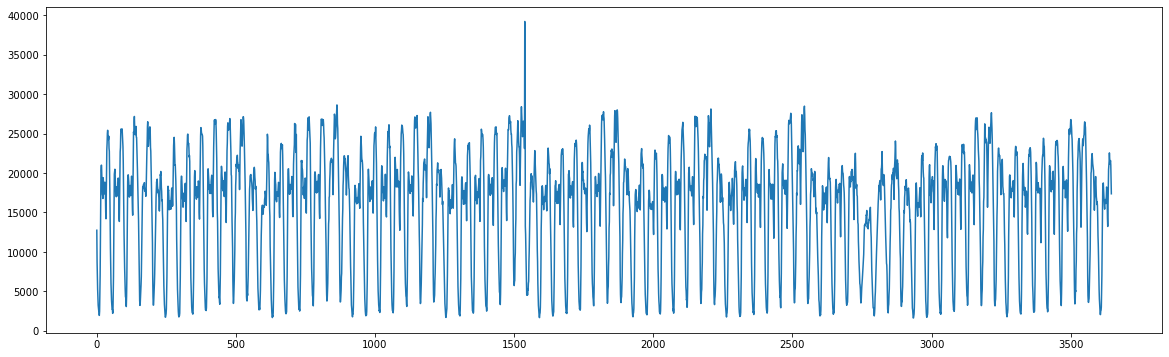

In [41]:
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']
ts_taxi = np.reshape(data.to_numpy(dtype=np.float64), newshape=(-1,))

T_taxi = [val for i,val in enumerate(ts_taxi) if i % 2 == 0]
T_taxi = np.asarray(ts_taxi)

plt.plot(T_taxi)
plt.show()

In [42]:
#set m and k
m = 50; k = 10;

In [43]:
#stumpy
mp_out = stumpy_top_k_discords(T_taxi, m, k)
mp_out

array([[1494, 3.5268153024066717, 2502],
       [1536, 3.4891959202175777, 192],
       [2704, 3.4023316427088326, 2803],
       [1518, 3.093376509535239, 846],
       [2726, 2.770581012902818, 2871],
       [2767, 2.642040969753919, 2818],
       [2740, 2.6154277166261073, 578],
       [2821, 2.2292277455863254, 2910],
       [2781, 1.8949213350363567, 2831],
       [2864, 1.8208725719146936, 1856]], dtype=object)

In [44]:
# for now, we choose value of `r` based on the output of stumpy, just to see the outcomes of `_murlin`. 
#Later, we will see that `r` will be initialized and updated in the parent function `_discords`.

tic = time.time()
out = _discords(T_taxi, m, k)
toc = time.time()

print('running time: ', toc-tic)
print('--------------------')

out

running time:  3.277238130569458
--------------------


array([[1494, 3.5268153024066797, 2502],
       [1536, 3.4891959202175764, 192],
       [2704, 3.402331642708777, 2803],
       [1518, 3.09337650953523, 846],
       [2726, 2.770581012902826, 2871],
       [2767, 2.6420409697538583, 2818],
       [2740, 2.6154277166261073, 578],
       [2821, 2.229227745586343, 2910],
       [2781, 1.8949213350364211, 2831],
       [2864, 1.8208725719146996, 1856]], dtype=object)

In [45]:
np.testing.assert_almost_equal(mp_out, out)

**How about the performance of `_murlin` on a randomly-generated time series (from `np.random.uniform`)?**

In [46]:
np.random.seed(seed=10)
T = np.random.uniform(low=-100.0, high=100.0, size=5000)
m = 50
k = 5

In [47]:
#use STUMPY:
tic = time.time()
mp_out = stumpy_top_k_discords(T, m, k)
toc = time.time()

print('running time: ', toc-tic)
print('--------------------')

mp_out

running time:  0.04187321662902832
--------------------


array([[2691, 7.737259840753032, 3303],
       [4017, 7.6548012236676355, 3934],
       [4426, 7.626027116981462, 2620],
       [1508, 7.624255432471149, 4595],
       [1417, 7.616814755546456, 2455]], dtype=object)

In [48]:
tic = time.time()
out = _discords(T, m, k)
toc = time.time()

print('running time: ', toc-tic)
print('--------------------')

out

running time:  8.506269931793213
--------------------


array([[2691, 7.7372598407530315, 3303],
       [4017, 7.6548012236676355, 3934],
       [4426, 7.626027116981461, 2620],
       [1508, 7.62425543247115, 4595],
       [1417, 7.616814755546457, 2455]], dtype=object)

In [49]:
np.testing.assert_almost_equal(mp_out, out)

In [50]:
def discords(T, m, k=1, r=None, decay=None, s=None, include=None, finite=False):
    """
    This funciton finds `top-k` discords for each length m in numpy indexing [min_m: max_m+1].
    
    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence from which to get top-k discords
    
    m : int
        Window size of discord.
    
    k: int, default 1
        number of discords to discover (for each lenght of subsequence).
    
    r : float, default None
        An initial value for r. An ideal value for r should be close to discord distance. 
        If you do not have a good guess about r, it is recommended leaving this input to None.
        The smallest value allowed for r is config.STUMPY_MIN_DISCORD_DISTANCE, which is set to 1e-6 by default.

    decay: numpy.ndarray
        a 1-dim array of length k with values each between 0 and 1. 
        The decay[i] represents the rate of decrease of `r` for i-th discord. 
        
    s : int, default None
        The sampling interval, that defaults to int(0.001 * len(T)). 
        
    include : ndarray
        is a 1-dim boolean array, whose length is the total number of subsquences in the time series. 
        `include[i]` is True if the subsequence with start index `i` is eligible to be considered as one of the 
        prospective candidates. Therefore, if `include[i]` is False, `is_cands[i]` will be False as well. 
        When include=None (default), all the elements of `include` are set to True. 
    
    finite: bool, default False
        If True, subsequence with infinite values will be ignored.  
    
    Returns
    --------
    out: ndarray
        has shape (k, 3). The i-th row cosists of information of i-th discord.
        First column is the discord index. Second column is the distance of discard to its Nearest Neighbor.
        And, third column is the index of discord's NearestNeighbor. The discords are sorted according to their 
        distances to their nearest neighbor. If number of discovered discords is less than k, the remaining rows
        are filled with [-1, np.NINF, -1].
    
    
    NOTE
    --------
    (1) Please note that higher values for decay may lead to a faster discovery 
        of candidates; however, it can result in a large set of candidates which can slow down the process. 
    
    (2) To ignore trival matches, the original paper used a full window size m. However, this implementation uses the default 
        STUMPY setting of m/4.
    
    Ref:
    DOI: 10.1109/ICDM50108.2020.00147
    """    
    return _discords(T, m, k, r, decay, s, include, finite)

## Bonus: Find discords for range of `m`

**Borrowed from MERLIN paper:** If you want to find discords for a range of `m`, you can then take advantage of input `r`. Example below shows how this works for getting top-2 discords for subsequence lengths-range `[500:506]`.

In [51]:
data = loadmat("MERLIN_datasets\\NoisySine.mat") #toy data
T = data['T'].reshape(-1,)

min_m = 500
max_m = 505

k=2

In [52]:
discords_list = []

r = None
for m in range(min_m, max_m+1): 
    top_k_discords = discords(T, m, k, r) 
    discords_list.append(top_k_discords)
    r = top_k_discords[0,1]

n_discords = [k]*(max_m - min_m + 1)
out = np.empty((sum(n_discords), 4), dtype=object)
out[:, 0] = np.repeat(np.arange(min_m, max_m+1), n_discords)
out[:, 1:] = np.vstack(discords_list)

print(out)

[[500 647 10.249998271106335 207]
 [500 864 10.2168841325517 1241]
 [501 647 10.23926271968037 207]
 [501 863 10.208112390984075 1240]
 [502 647 10.228567284411206 207]
 [502 774 10.196621139063918 1151]
 [503 717 10.220910104620353 277]
 [503 908 10.192931908753042 1285]
 [504 692 10.228598715473 252]
 [504 910 10.203003166459244 1287]
 [505 691 10.238772511211097 251]
 [505 911 10.213658314483652 1288]]


In [53]:
#use stumpy to find top-k discords for subsequence length-range from `min_m` to `max_m`
discords_list = []
for m in range(min_m, max_m+1):
    top_k_discords = stumpy_top_k_discords(T, m, k)
    discords_list.append(top_k_discords)

n_discords = [item.shape[0] for item in discords_list]
mp_out = np.empty((sum(n_discords), 4), dtype=object)
mp_out[:, 0] = np.repeat(np.arange(min_m, max_m+1), n_discords)
mp_out[:, 1:] = np.vstack(discords_list)

print(mp_out)

[[500 647 10.249998271106346 207]
 [500 864 10.216884132551765 1241]
 [501 647 10.23926271968037 207]
 [501 863 10.208112390984102 1240]
 [502 647 10.228567284411238 207]
 [502 774 10.196621139063884 1151]
 [503 717 10.220910104620325 277]
 [503 908 10.192931908753097 1285]
 [504 692 10.228598715472936 252]
 [504 910 10.20300316645917 1287]
 [505 691 10.238772511211103 251]
 [505 911 10.213658314483597 1288]]


In [54]:
#compare results
np.testing.assert_almost_equal(mp_out, out)